# Discovering the Higgs Boson (again)

In 2012 we discovered a particle consistent with the properties of the Standard Model (SM) Higgs boson. However, there are a lot more properties we need to measure to see if this is exactly the particle we think it is and if that discovery allows for other "beyond the Standard Model" theories. 

In the Standard Model, the Higgs boson "gives" mass to all elementary particles by interacting with them - the stronger the interaction, the heavier the particle. However, if there is physics beyond the SM, this doesn't necessarily have to be the case for all particles!

One of the properties we want to measure is the interaction of this boson with muons, elementary particles similar to electrons but heavier. The way we do this in high-energy physics (HEP) is by looking for resonances, or bumps, in our data.

### Data collection - CERN, the LHC, and CMS
Underneath the European Organization for Nuclear Research (CERN) in Meyrin, Switzerland, lies the Large Hadron Collider (LHC). The LHC smashes anti-parallel beams of protons into each other at speeds close to that of light. The beams collide inside several detectors, one of which is the Compact Muon Solenoid (CMS). CMS uses many subsystems of particle detectors to measure the debris flying out from the collisions in order to reconstruct exactly what happened when the protons interacted with each other to create other particles. 

We want to find events where the colliding protons produce a Higgs boson with a mass of 125 GeV (where the 2012 boson was seen) which then becomes a pair of muons, one with a positive charge and one with negative.

Below is a reconstruction of an event where a Z boson decayed to two muons (red lines).

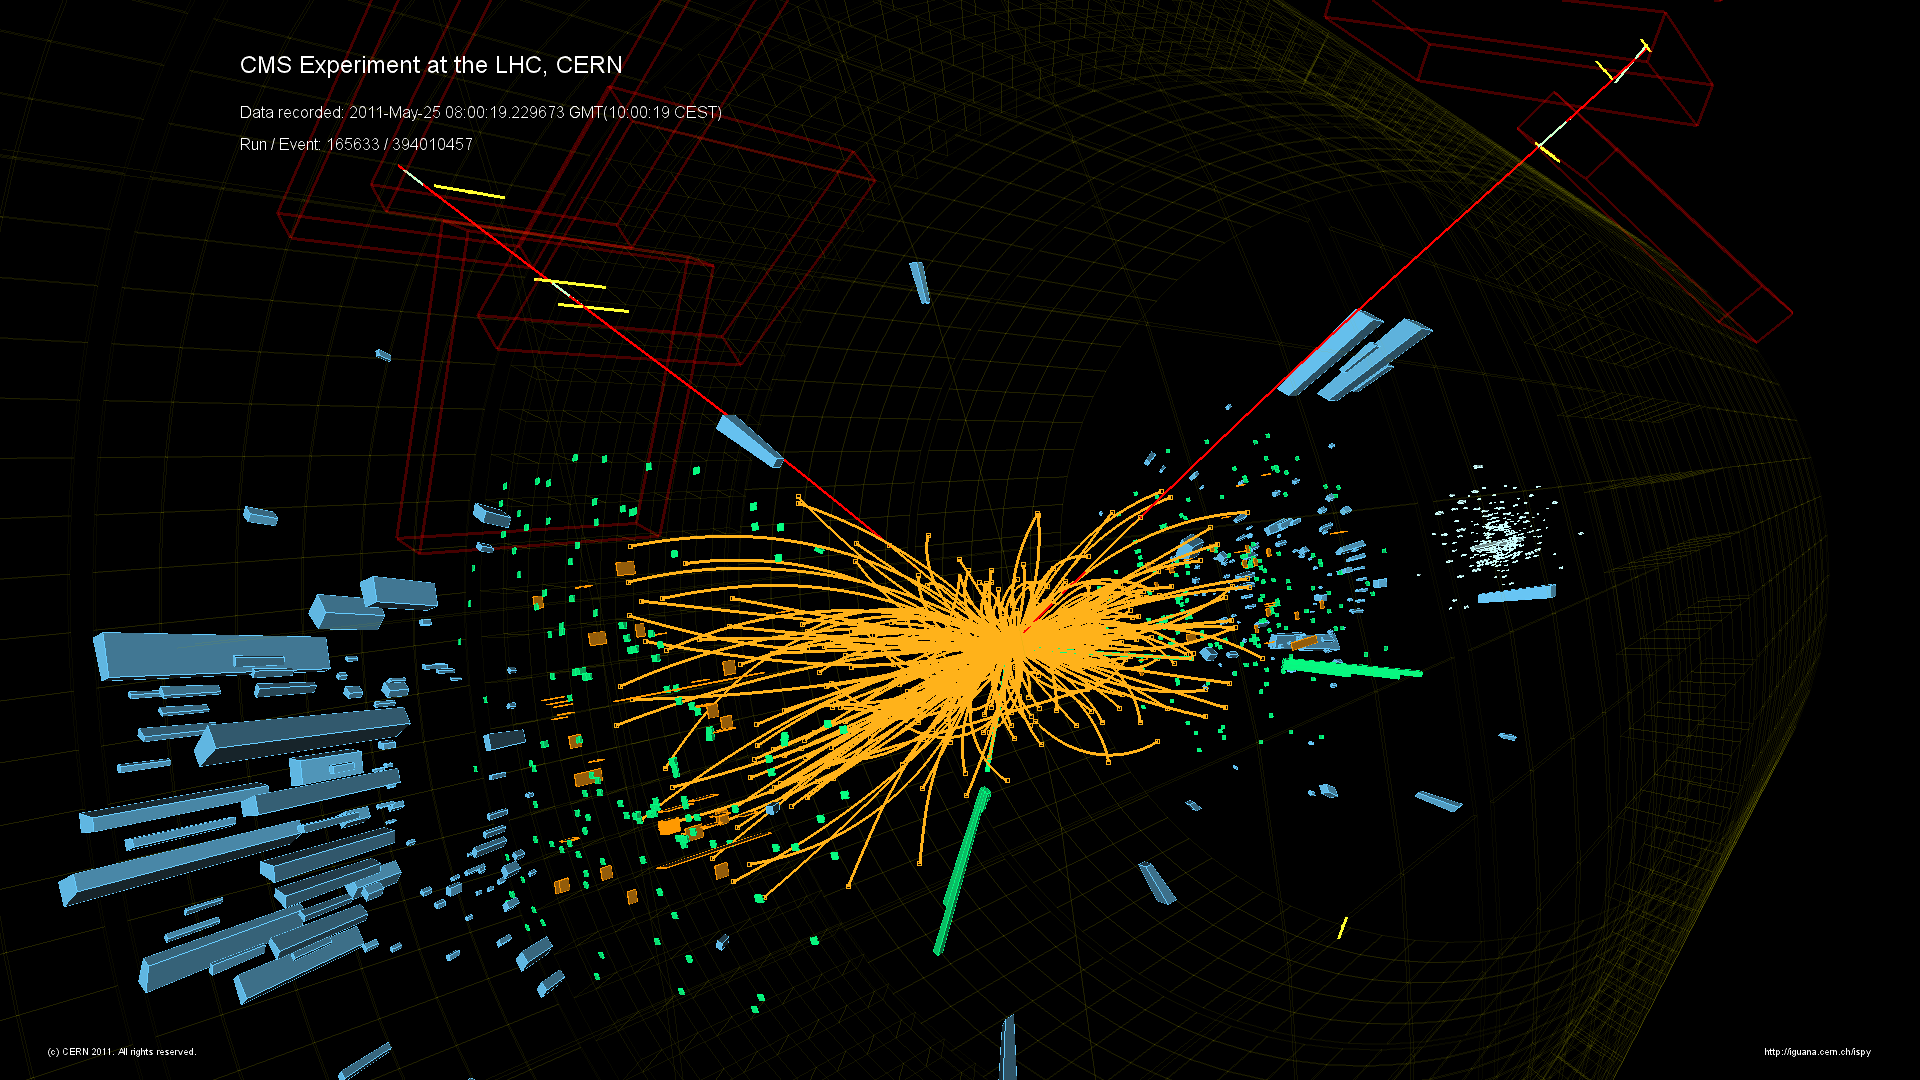

Thousands of these collisions happen per second - our biggest challenge then is separate the signal from the noise. One of the most popular ways to do this in HEP is to sort events into categories based on certain features which are characteristic of either signal or background processes; in each category we can maximize the signal-to-background ratio and then recombine our results at the end. This creates a more sensitive search than could be acheived with a single category.

### Data categorization - discriminating variables
There are five ways that we consider for a Higgs to be produced:
* Vector boson fusion (VBF)
    Signature: Two energetic jets pointing opposite directions
* Gluon-gluon fusion (GGF)
    Signature: lower dimuon momentum due to energy loss in the initial state
* Associated production with a W+, W-, or Z boson (WPlusH, WMinusH, ZH)
    Signature: more missing transverse energy due to neutrinos escaping the detector
    
So, the variables we will look at are the muon momentum (pT), the dimuon momentum (dimu pT), missing transverse energy (MET), and the number of jets along with the opening angle between the two most energetic.

To determine where we will place our cuts, we compare what we would expect for the signal (fake data, a.k.a. Monte Carlo) to what we would expect for the background.

##### Setup

In [1]:
import os
import sys
import math

import ROOT

import CMS_lumi as CMS_lumi
import tdrstyle as tdrstyle
from datasets import dsetdb

tdrstyle.setTDRStyle()
ROOT.gStyle.SetPalette(1)
ROOT.gROOT.ProcessLine('gErrorIgnoreLevel = 2001;');

class Dataset(object):
    def __init__(self, name, filepath):
        self.name = name
        self.tfilename = filepath
        self.tfile = ROOT.TFile.Open(self.tfilename)
        try:
            # get xsec and sumw/nevents
            tsummary = self.tfile.Get('Summary')
            tsummary.GetEntry(0)
            self.xsec = tsummary.tCrossSec
            self.sumw = 0.
            self.nevt = 0
            for entry in range(tsummary.GetEntries()):
                tsummary.GetEntry(entry)
                self.sumw += tsummary.tSumWts
                self.nevt += tsummary.tNumEvts
        except:
            print 'ERROR opening file ' + self.tfilename
            self.tfile = None
            self.xsec = -1.
            self.sumw = -1.
            self.nevt = -1


        # sig, bkg, or data
        self.kind = dsetdb[name]['kind']
        # for the stack
        self.group = dsetdb[name]['group']
        # for the legend
        self.label = dsetdb[name]['label']
        # if data
        self.lumi = dsetdb[name]['lumi'] if self.group=='data' else -1.

    def set_xsec(self, xsec):
        self.xsec = xsec
    def set_sumwts(self, sumw):
        self.sumw = sumw

    def get_label(self):
        return self.label
    def get_lumi(self):
        return self.lumi
    def get_tfile(self):
        return self.tfile
    def get_hist(self, histname):
        return self.tfile.Get(histname)
    
    def get_scale(self, lumi):
        return (lumi * self.xsec) / self.sumw


    def print_info(self):
        print
        print 'self.name  = ' + self.name
        print 'self.tfile = ' + self.tfilename
        print 'self.kind  = ' + self.kind
        print 'self.group = ' + self.group
        print 'self.label = ' + self.label
        print 'self.lumi  = ' + str(self.lumi)
        print 'self.xsec  = ' + str(self.xsec)
        print 'self.sumw  = ' + str(self.sumw)
        print 'self.nevt  = ' + str(self.nevt)
        print

Welcome to JupyROOT 6.10/08


In [2]:
# list of signal monte carlo
sig_list = [
    'GluGlu_HToMuMu',
    'VBF_HToMuMu',
    'WMinusH_HToMuMu',
    'WPlusH_HToMuMu',
    'ZH_HToMuMu',
]
# list of background monte carlo
bkg_list = [
    'DYJetsToLL',
    'TTJets',
    'ZZTo2L2Nu',
    'ZZTo2L2Q',
    'ZZTo4L',
    'WZTo2L2Q',
    'WZTo3LNu',
    'TTZToLLNuNu',
]


# set up lists of Dataset objects
d_sig = []
d_bkg = []
for d in sig_list:
    d_sig.append(
        Dataset(d, 'data/ana_2Mu_{0}.root'.format(d))
    )
for d in bkg_list:
    d_bkg.append(
        Dataset(d, 'data/ana_2Mu_{0}.root'.format(d))
    )
# only have one data
d_data = Dataset('SingleMuon_Run2016', 'data/ana_2Mu_SingleMuon_Run2016.root')

# check a few Dataset objects
#d_sig[0].print_info()
#d_bkg[-1].print_info()
#d_data.print_info()

# retrieve, scale, and format histograms
lumi = d_data.get_lumi() # picobarns
sig_scale = 100000.
c_width, c_height = 700, 450


hists = { d : {} for d in sig_list+bkg_list+['data']}
discrim_vars = [
    'hMuPt',
    'hDiMuPt',
    'hMET',
    'hNumBJets',
    'hNumJets',
    'hDiJetInvMass',
    'hDiJetDeltaEta',
    'hDiMuInvMass',
]

for v in discrim_vars:
    
    h_ = ROOT.TH1F(d_data.get_hist('categories/{v}_cat00'.format(v=v)))
    h_.SetTitle('Observed')
    h_.SetMarkerSize(0.6)
    h_.SetMarkerStyle(20)
    h_.SetMarkerColor(ROOT.kBlack)
    h_.SetLineColor(ROOT.kBlack)
    hists['data'][v] = h_

    for i,d in enumerate(sig_list):
        h_ = d_sig[i].get_hist('categories/{v}_cat00'.format(v=v))
        h_.SetTitle(d)
        h_.SetFillColor(0)
        h_.SetLineColor(2+i)
        h_.SetLineWidth(2)
        h_.Scale(d_sig[i].get_scale(lumi * sig_scale))
        if 'Glu' not in d: h_.Scale(100)
        if 'VBF' in d: h_.Scale(.1)
        hists[d][v] = h_

    for i,d in enumerate(bkg_list):
        h_ = d_bkg[i].get_hist('categories/{v}_cat00'.format(v=v))
        h_.SetTitle(d)
        h_.SetFillColor(26+3*i)
        h_.SetLineColor(26+3*i)
        h_.Scale(d_bkg[i].get_scale(lumi))
        hists[d][v] = h_

##### Discriminating variable - dimuon-system transverse momentum

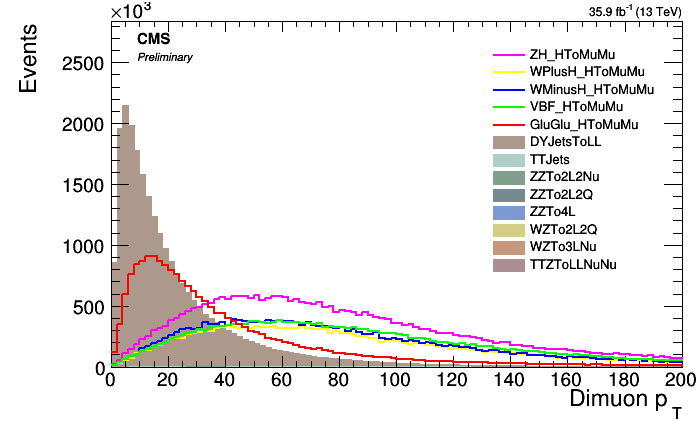

In [3]:
varname = 'hDiMuPt'
xtitle = 'Dimuon p_{T}'
    
# create canvas
canv = ROOT.TCanvas(varname,varname,50,50,c_width,c_height)

# stack backgrounds
stack = ROOT.THStack('stack','stack')
for d in reversed(bkg_list):
    stack.Add(hists[d][varname])

stack.Draw('hist')
stack.GetXaxis().SetTitle(xtitle)
stack.GetYaxis().SetTitle('Events')
stack.GetYaxis().SetLabelSize(0.05)
#stack.SetMinimum(ymin)
stack.SetMaximum(stack.GetHistogram().GetMaximum()*1.2)
stack.GetXaxis().SetRangeUser(0.,200.)

# draw signals
for d in reversed(sig_list):
    hists[d][varname].Draw('hist same')

# cms styling
period_int = 4
lumipos = 11
CMS_lumi.writeExtraText = True
CMS_lumi.extraText = 'Preliminary'
CMS_lumi.lumi_13TeV = '%0.1f fb^{-1}' % (float(lumi)/1000.)
if lumi < 1000:
    CMS_lumi.lumi_13TeV = '%0.1f pb^{-1}' % (float(lumi))
CMS_lumi.CMS_lumi(canv,period_int,lumipos)

# create universal legend
entries = []
for d in reversed(sig_list):
    entries += [[hists[d][varname],hists[d][varname].GetTitle(),'l']]
for h in reversed(stack.GetHists()):
    entries += [[h,h.GetTitle(),'f']]

legend = ROOT.TLegend(0.7,  0.35,  0.95,  0.89,'','NDC')
legend.SetTextFont(42)
legend.SetBorderSize(0)
legend.SetFillColor(0)
for entry in entries:
    legend.AddEntry(*entry)
legend.Draw()

legend.Draw()
canv.Draw()

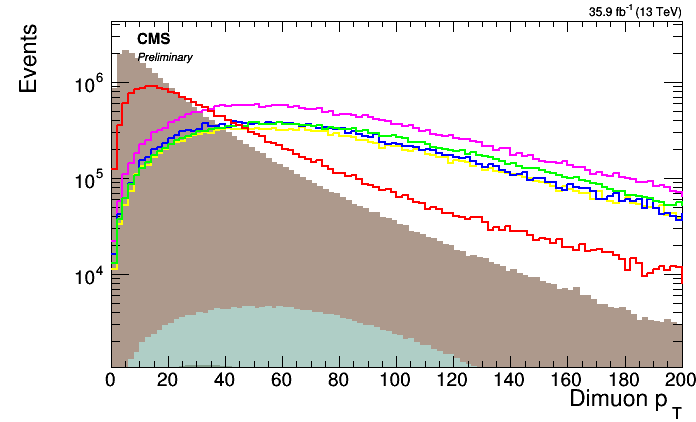

In [4]:
canv.SetLogy()
# legend will only be shown once for clarity
legend.Delete()
canv.Draw()

##### Discriminating variable - missing transverse energy (MET)

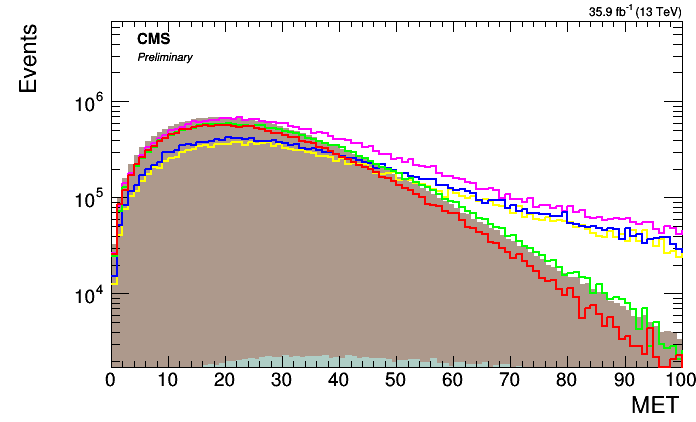

In [5]:
varname = 'hMET'
xtitle = 'MET'
    
# create canvas
canv2 = ROOT.TCanvas(varname,varname,50,50,c_width,c_height)
canv2.cd()

# stack backgrounds
stack2 = ROOT.THStack('stack','stack')
for d in reversed(bkg_list):
    stack2.Add(hists[d][varname])

stack2.Draw('hist')
stack2.GetXaxis().SetTitle(xtitle)
stack2.GetYaxis().SetTitle('Events')
stack2.GetYaxis().SetLabelSize(0.05)
stack2.SetMaximum(stack.GetHistogram().GetMaximum())
stack2.GetXaxis().SetRangeUser(0.,100.)

# draw signals
for d in reversed(sig_list):
    hists[d][varname].Draw('hist same')

# cms styling
CMS_lumi.CMS_lumi(canv2,period_int,lumipos)

canv2.SetLogy()
canv2.Draw()

##### Discriminating variable - dijet-system opening angle

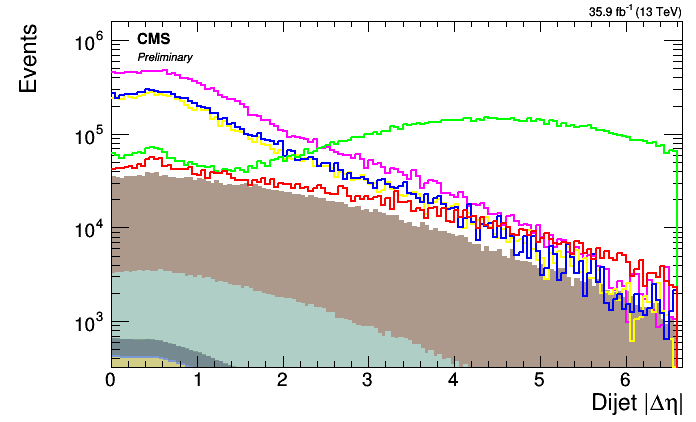

In [6]:
varname = 'hDiJetDeltaEta'
xtitle = 'Dijet |#Delta#eta|'
    
# create canvas
canv3 = ROOT.TCanvas(varname,varname,c_width,c_height)
canv3.cd()

# stack backgrounds
stack3 = ROOT.THStack('stack','stack')
for d in reversed(bkg_list):
    stack3.Add(hists[d][varname])

stack3.Draw('hist')
stack3.GetXaxis().SetTitle(xtitle)
stack3.GetYaxis().SetTitle('Events')
stack3.GetYaxis().SetLabelSize(0.05)
stack3.SetMaximum(1000000.)
stack3.GetXaxis().SetRangeUser(0.,10.)

# draw signals
for d in reversed(sig_list):
    hists[d][varname].Draw('hist same')

# cms styling
CMS_lumi.CMS_lumi(canv3,period_int,lumipos)

canv3.SetLogy()
canv3.Draw()

##### Discriminating variable - dijet-system invariant mass

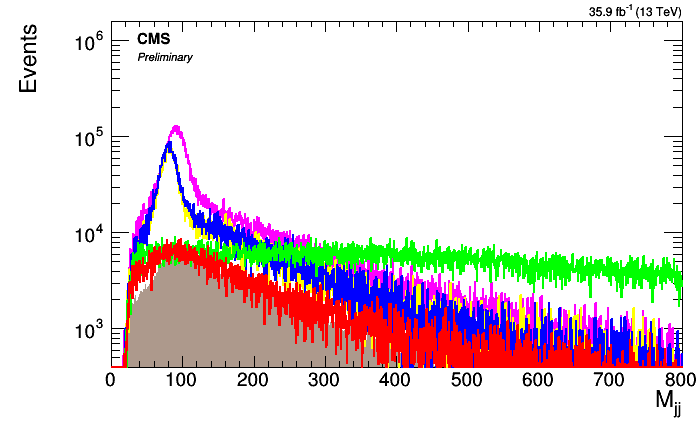

In [7]:
varname = 'hDiJetInvMass'
xtitle = 'M_{jj}'
    
# create canvas
canv5 = ROOT.TCanvas(varname,varname,c_width,c_height)
canv5.cd()

# stack backgrounds
stack5 = ROOT.THStack('stack','stack')
for d in reversed(bkg_list):
    stack5.Add(hists[d][varname])

stack5.Draw('hist')
stack5.GetXaxis().SetTitle(xtitle)
stack5.GetYaxis().SetTitle('Events')
stack5.GetYaxis().SetLabelSize(0.05)
stack5.SetMaximum(1000000.)
stack5.GetXaxis().SetRangeUser(0.,800.)

# draw signals
for d in reversed(sig_list):
    hists[d][varname].Draw('hist same')

# cms styling
CMS_lumi.CMS_lumi(canv5,period_int,lumipos)

canv5.SetLogy()
canv5.Draw()

##### Discriminating variable - number of jets

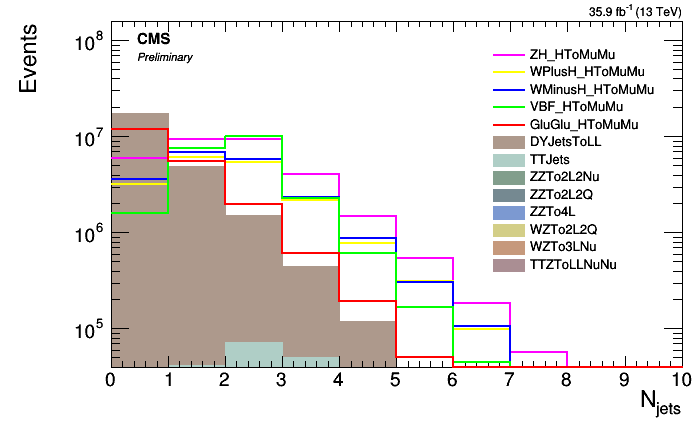

In [8]:
varname = 'hNumJets'
xtitle = 'N_{jets}'
    
# create canvas
canv4 = ROOT.TCanvas(varname,varname,c_width,c_height)
canv4.cd()

# stack backgrounds
stack4 = ROOT.THStack('stack','stack')
for d in reversed(bkg_list):
    stack4.Add(hists[d][varname])

stack4.Draw('hist')
stack4.GetXaxis().SetTitle(xtitle)
stack4.GetYaxis().SetTitle('Events')
stack4.GetYaxis().SetLabelSize(0.05)
stack4.SetMaximum(100000000)
stack4.GetXaxis().SetRangeUser(0.,10.)

# draw signals
for d in reversed(sig_list):
    hists[d][varname].Draw('hist same')

# cms styling
CMS_lumi.CMS_lumi(canv4,period_int,lumipos)

canv4.SetLogy()
legend = ROOT.TLegend(0.7,  0.35,  0.95,  0.89,'','NDC')
legend.SetTextFont(42)
legend.SetBorderSize(0)
legend.SetFillColor(0)
for entry in entries:
    legend.AddEntry(*entry)
legend.Draw()
legend.Draw()
canv4.Draw()

### Data categorization - the categories
These are the variables we will use to separate our events by Higgs production mode.

The highest combined significance (and therefore the most sensitive overall measurement) is acheived with the following:
* VBF Tight: dijet mass above 650 GeV with opening angle greater than 3.5
* 2-jet Tight: dijet mass above 250 GeV with dimuon transverse momentum above 50 GeV
* 2-jet Loose: two jets but not Tight categories
* 0/1-jet Tight: dimuon transverse momentum above 10 GeV
* 0/1-jet Loose: zero or one jet but not Tight category

(NB: 0/1-jet events are further categorized by where each muon track was measured, grouping more sensitive measurements together. This yields a total of 15 categories.)

### Analysis evaluation
Finally, to measure the coupling (our main goal), we will need to look at (a) the collected data, (b) the signal MC, and (c) the background MC. However, the frequency with which the Higgs decays directly to two muons is so small that we cannot see it with the amount of data we collected in 2016. To demonstrate this, let's look at the unblinded dimuon mass spectrum in a range that included both our signal region (120-130 GeV) as well as the Z peak at 91 GeV, formed when a Z boson decays directly to two muons. 

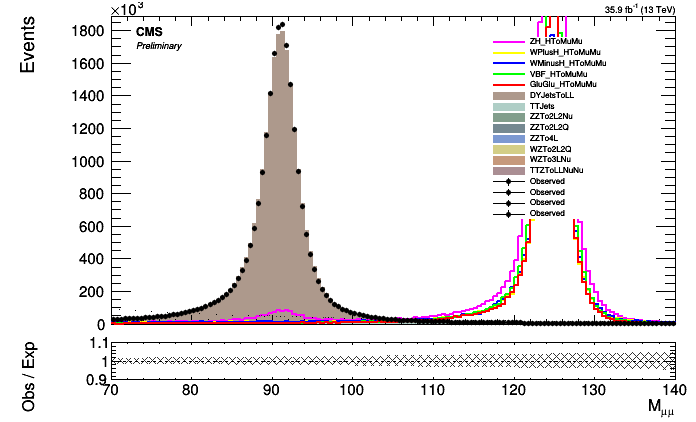

In [12]:
varname = 'hDiMuInvMass'
xtitle = 'M_{#mu#mu}'
h_data = hists['data'][varname]

# create canvas
canvZ = ROOT.TCanvas(varname,varname,c_width,c_height)
plotpad = ROOT.TPad('plotpad', 'plotpad', 0.0, 0.20, 1.0, 1.0)
plotpad.SetBottomMargin(0.04)
plotpad.SetRightMargin(0.03)
plotpad.Draw()
ratiopad = ROOT.TPad('pullpad', 'pullpad', 0.0, 0.0, 1.0, 0.20)
ratiopad.SetTopMargin(0.06)
ratiopad.SetRightMargin(0.03)
ratiopad.SetBottomMargin(0.5)
ratiopad.SetLeftMargin(0.16)
ratiopad.SetTickx(1)
ratiopad.SetTicky(1)
ratiopad.Draw()
plotpad.cd()

# stack backgrounds
stackZ = ROOT.THStack('stackZ','stackZ')
for d in reversed(bkg_list):
    stackZ.Add(hists[d][varname])

stackZ.Draw('hist')
stackZ.GetXaxis().SetTitle(xtitle)
stackZ.GetYaxis().SetTitle('Events')
stackZ.GetYaxis().SetLabelSize(0.05)
#stackZ.SetMaximum(100000000)
stackZ.GetXaxis().SetRangeUser(70.,140.)

# draw signals
for d in reversed(sig_list):
    hists[d][varname].Draw('hist same')
    
# staterr for stack
stackZ.GetHistogram().GetXaxis().SetLabelOffset(999)
staterr = stack.GetStack().Last().Clone('{0}_staterr'.format(stack.GetName))
staterr.SetFillColor(ROOT.kGray+3)
staterr.SetLineColor(ROOT.kGray+3)
staterr.SetLineWidth(0)
staterr.SetMarkerSize(0)
staterr.SetFillStyle(3013)
staterr.Draw('e2 same')
h_data.Draw('ex0 same')

# make the legend
legend.AddEntry(h_data,h_data.GetTitle(),'lep')
legend.Draw()

# cms styling
CMS_lumi.CMS_lumi(plotpad,period_int,lumipos)


# the ratio portion for stack
denom = stack.GetStack().Last().Clone('denom')
ratiostaterr = denom.Clone('{0}_ratiostaterr'.format(denom.GetName))
ratiostaterr.SetStats(0)
ratiostaterr.SetTitle('')
ratiostaterr.GetYaxis().SetTitle('Obs / Exp')
ratiostaterr.SetMaximum(1.1)
ratiostaterr.SetMinimum(0.9)
ratiostaterr.SetMarkerSize(0)
ratiostaterr.SetFillColor(ROOT.kGray+3)
ratiostaterr.SetFillStyle(3013)
ratiostaterr.GetXaxis().SetLabelSize(0.19)
ratiostaterr.GetXaxis().SetTitleSize(0.21)
ratiostaterr.GetXaxis().SetTitleOffset(1.0)
ratiostaterr.GetXaxis().SetLabelOffset(0.03)
ratiostaterr.GetYaxis().SetLabelSize(0.19)
ratiostaterr.GetYaxis().SetLabelOffset(0.006)
ratiostaterr.GetYaxis().SetTitleSize(0.21)
ratiostaterr.GetYaxis().SetTitleOffset(0.35)
ratiostaterr.GetYaxis().SetNdivisions(503)

# bin by bin errors
for i in range(denom.GetNbinsX()+2):
    ratiostaterr.SetBinContent(i, 1.0)
    if denom.GetBinContent(i)>1e-6:  # not empty
        binerror = denom.GetBinError(i) / denom.GetBinContent(i)
        ratiostaterr.SetBinError(i, binerror)
    else:
        ratiostaterr.SetBinError(i, 999.)
ratiostaterr.SetXTitle(xtitle)

unityargs = [70.,1,140.,1]
ratiounity = ROOT.TLine(*unityargs)
ratiounity.SetLineStyle(2)

# ratio for data
dataratio = h_data.Clone('ratio_{0}'.format(h_data.GetName()))
for b in range(h_data.GetNbinsX()):
    nVal = h_data.GetBinContent(b+1)
    nErr = h_data.GetBinError(b+1)
    dVal = denom.GetBinContent(b+1)
    if dVal>1e-6:
        val = nVal/dVal
        err = nErr/dVal
    else:
        val = 0
        err = 0
    dataratio.SetBinContent(b+1,val)
    dataratio.SetBinError(b+1,err)

# draw ratio
if ratiopad != ROOT.TVirtualPad.Pad(): ratiopad.cd()
ratiostaterr.Draw('e2')
ratiostaterr.GetXaxis().SetRangeUser(70.,140.)
ratiounity.Draw('same')
dataratio.Draw('0P same')

canvZ.Draw()